In [1]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/ #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import torchsummary
import matplotlib.pyplot as plt


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 50
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

100%|██████████| 170498071/170498071 [01:48<00:00, 1568794.70it/s] 


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [2]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.conv = conv3x3(3, 32)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        # self.layer1 = self.make_layer(block, 16, layers[0])
        # self.layer2 = self.make_layer(block, 32, layers[1], 2)
        # self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.layer1 = self.make_layer(block, 32, layers[0])
        self.layer2 = self.make_layer(block, 64, layers[1], 2)
        self.layer3 = self.make_layer(block, 128, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8) #8
        self.fc = nn.Linear(128, num_classes)
        # self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

# Print the summary of the model
torchsummary.summary(model, input_size=(3, 32, 32))


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
    ResidualBlock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 32,

Accuracy of the model on the test images: 90.83 %


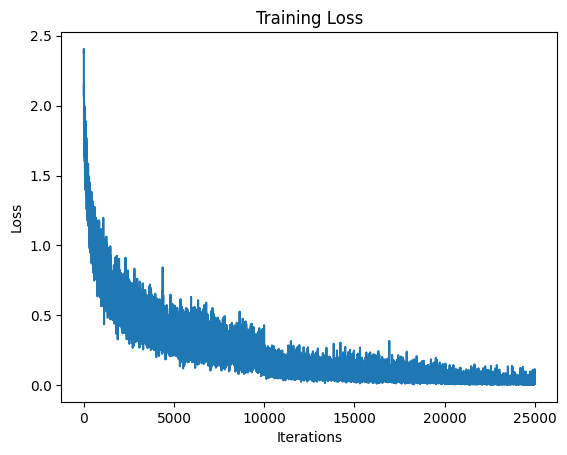

In [3]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate

loss_list = []  # initialize empty list to store loss values
for epoch in range(num_epochs):
    
    # initialize the tqdm progress bar with the length of the train_loader
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for i, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update the progress bar with the current loss
        progress_bar.set_postfix({'loss': loss.item()})
        loss_list.append(loss.item())
        
    # close the progress bar
    progress_bar.close()

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

# Plot the loss graph
plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Accuracy of the pretrained model on the test images: 91.23 %


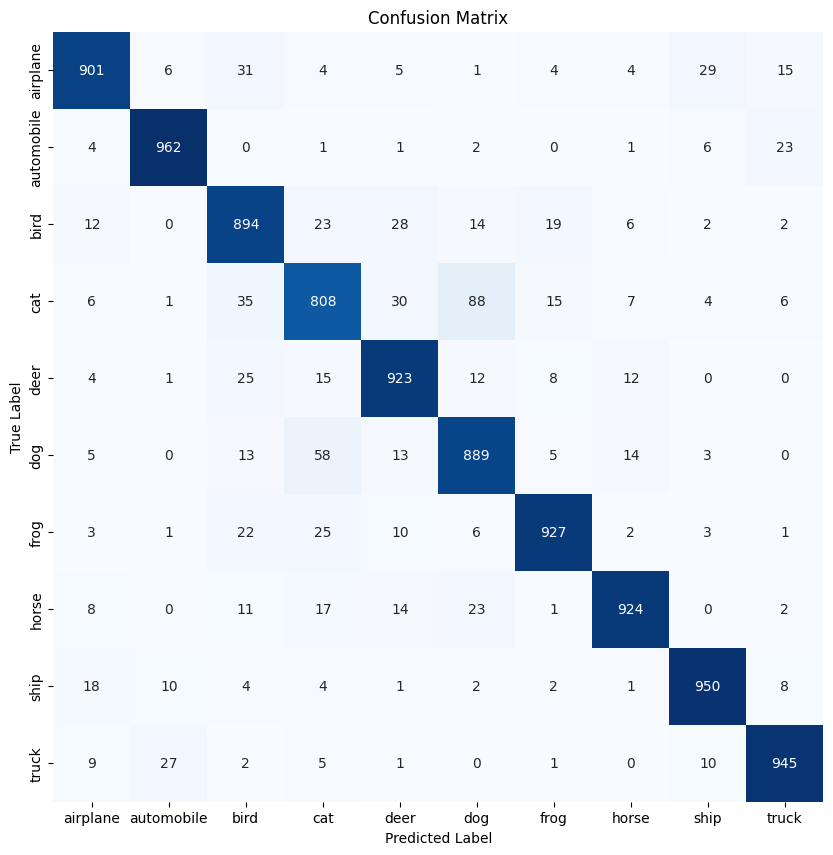

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the pretrained model
model.load_state_dict(torch.load('resnet.ckpt'))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print('Accuracy of the pretrained model on the test images: {} %'.format(100 * correct / total))

# Compute the confusion matrix
classes = test_dataset.classes
cm = confusion_matrix(all_labels, all_predicted)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=False, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
